In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# def make_tn(df):
#     depths = df.depth
#     maxamps = df.max_amp
#     df = df.copy().arrival_datetime.drop_duplicates()
#     tn = df.values
#     # time since last event
#     ts = []
#     # time until next event
#     tu = []
#     for n, t in enumerate(tn):
#         # we use a try/except block to take care of the 
#         # failure when looking before the array starts
#         # and after the array ends
#         try:
#             tn_minus1 = tn[n-1]
#             tn_plus1 = tn[n+1]
#             ts.append(t - tn_minus1)
#             tu.append(tn_plus1 - t)
#         except:
#             pass
    
#     tndf = pd.DataFrame(
#         {
#             'tn-1':ts
#             ,'tn':tn[1:]
#             ,'tn+1':tu
#             ,'depth':depths
#             ,'maxamp':maxamps
#         }
#         ,index=df[1:].index
#     )
#     tndf['tn-1'] = tndf['tn-1'].apply(lambda t: t.total_seconds())
#     tndf['tn+1'] = tndf['tn+1'].apply(lambda t: t.total_seconds())
#     return tndf

def import_data(file):
    df = pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df.origin_time)
    df['timediff'] = (df.datetime - df.datetime.min())
    df['timediff'] = df.timediff.apply(lambda t: t.total_seconds())
    df = df[df.max_amp > 0.1]

    depths = df.depth
    tn = df.datetime.values

    t_minus1 = []
    t_plus1 = [0]

    for n, t in enumerate(tn):
        try:
            t_minus1.append(pd.Timedelta(t - tn[n-1]).total_seconds())
            t_plus1.append(pd.Timedelta(tn[n+1] - t).total_seconds())
        except:
            pass
    # print(pd.Timedelta(tn[5] - tn[4]).total_seconds())
    t_minus1 = [0,] + t_minus1[1:]
    df['t_minus1'] = t_minus1
    df['t_plus1'] = t_plus1
    
    return df


In [2]:
# df141 = pd.read_csv('141precision.csv')
df141 = import_data('141precision.csv')
df141.columns

Index(['Unnamed: 0', 'id', 'depth', 'relative_depth', 'radius', 'aic_t',
       'aics', 'aic_maxes', 'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt', 'parrival',
       'max_amp', 'cum_amp', 'origin_time', 'init_arrival_time', 'datetime',
       'timediff', 't_minus1', 't_plus1'],
      dtype='object')

In [3]:
df141.dtypes

Unnamed: 0                         int64
id                                 int64
depth                            float64
relative_depth                   float64
radius                           float64
aic_t                             object
aics                              object
aic_maxes                         object
first_hydrophone                   int64
second_hydrophone                  int64
arrival_time                     float64
first_arrival                     object
second_arrival                    object
dt                               float64
parrival                          object
max_amp                          float64
cum_amp                          float64
origin_time                       object
init_arrival_time                float64
datetime             datetime64[ns, UTC]
timediff                         float64
t_minus1                         float64
t_plus1                          float64
dtype: object

In [4]:
df141['datetime'] = pd.to_datetime(df141.origin_time)

<Axes: xlabel='timediff', ylabel='depth'>

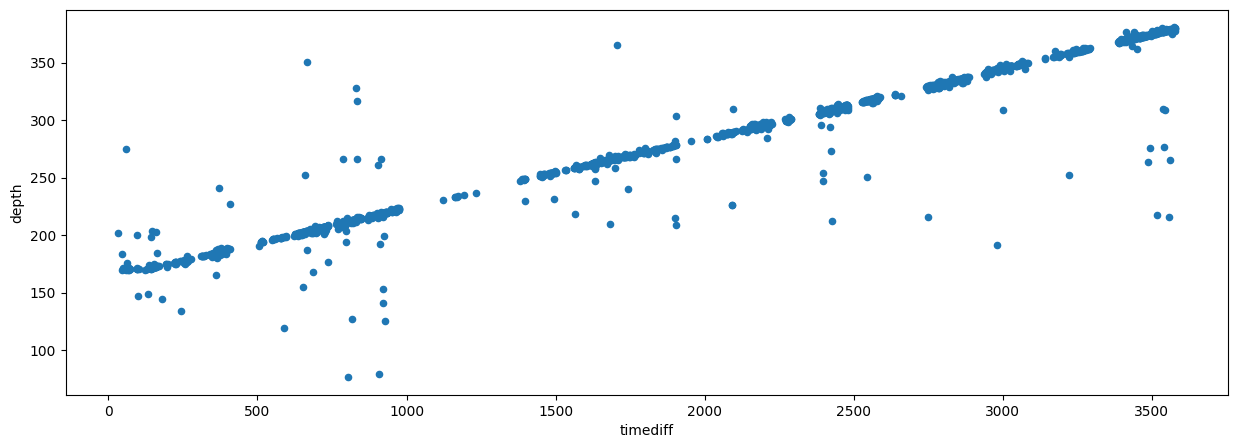

In [5]:
df141.plot.scatter(x='timediff', y='depth', figsize=(15,5))

<Axes: xlabel='t_minus1', ylabel='depth'>

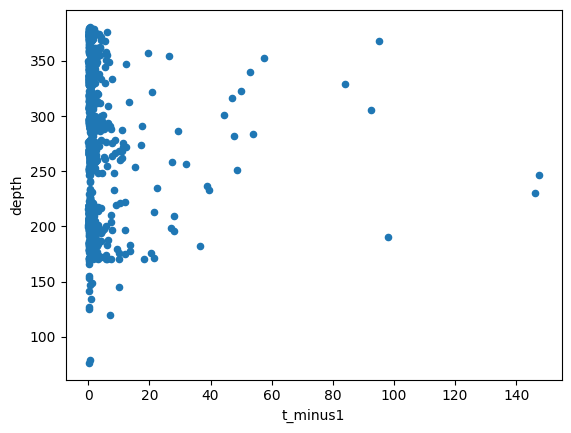

In [6]:
df141.plot.scatter(x='t_minus1', y='depth', )

In [7]:
df141.columns

Index(['Unnamed: 0', 'id', 'depth', 'relative_depth', 'radius', 'aic_t',
       'aics', 'aic_maxes', 'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt', 'parrival',
       'max_amp', 'cum_amp', 'origin_time', 'init_arrival_time', 'datetime',
       'timediff', 't_minus1', 't_plus1'],
      dtype='object')

In [16]:
x = df141.timediff.values
y = df141.id.values

X = np.linspace(x[0], x[-1], x.shape[0])
Y = np.linspace(y[0], y[-1], y.shape[0])
dY = Y - y
df141['detrend'] = dY

In [58]:
import sklearn.linear_model as linear_model

In [81]:
y = df141.id.values
x = df141.timediff.values

xy = np.vstack([x, y]).transpose()
xy

array([[  33.731 ,   16.    ],
       [  43.953 ,   20.    ],
       [  47.125 ,   25.    ],
       ...,
       [3577.499 , 2238.    ],
       [3578.4535, 2239.    ],
       [3579.3065, 2240.    ]])

In [103]:
xy.shape

(1931, 2)

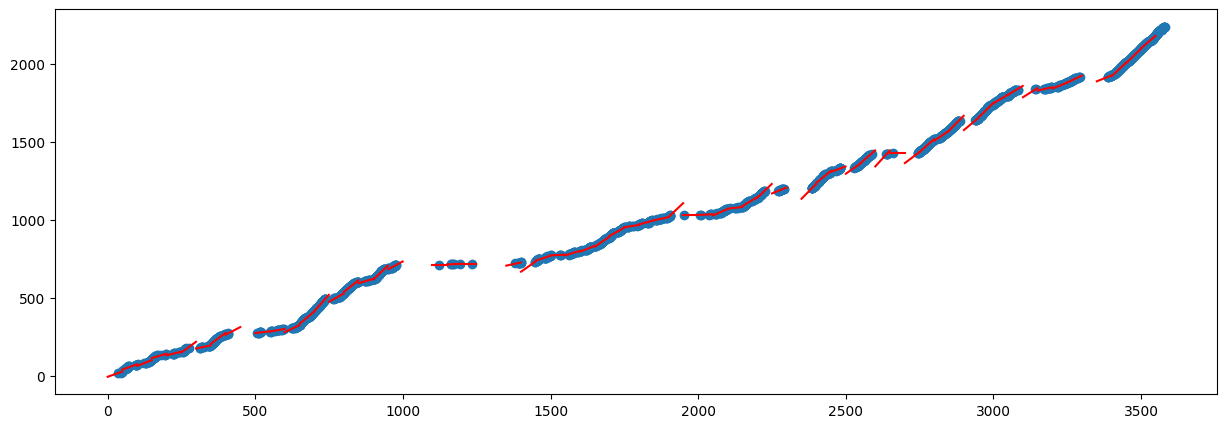

In [126]:
local_rate = []

y = df141.id.values
x = df141.timediff.values

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(x, y)

xy = np.vstack([x, y]).transpose()

window_size = 50

slopes = np.zeros_like(x)

windows = np.arange(0, x.max(), window_size).astype(int)[:-1]

for w in windows:
    idx = np.where(np.logical_and(x>=w, x<=w+window_size))[0]
    if idx.shape[0] == 0:
        pass
    else:
        xy_window = xy[idx]
        # xy_window = xy[w:w+window_size]
    
        # i = np.where(np.logical_and(a>=6, a<=10))
    
        lr = linear_model.LinearRegression(fit_intercept=True)
        lr.fit(xy_window[:,0].reshape(-1, 1), xy_window[:,1])
        slope = lr.coef_[0]
        intercept = lr.intercept_
        xmod = np.arange(w, w+window_size, 1)
        ymod = intercept + slope * xmod
        # print(intercept)
    
        ax.plot(xmod, ymod, color='red')

        slopes[idx] = intercept

df141['local_rate'] = slopes

In [127]:
vars_for_cluster = ['depth', 't_minus1', 't_plus1', 'timediff', 'id', 'detrend', 'local_rate']

In [128]:
vars_for_cluster

['depth', 't_minus1', 't_plus1', 'timediff', 'id', 'detrend', 'local_rate']

In [129]:
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler

In [130]:
X = df141[vars_for_cluster]
X = StandardScaler().fit_transform(X)

clusters = np.arange(3, 31, 1)
SSE = []

for n in clusters:
    km = cluster.KMeans(n_clusters=n, n_init=10)
    km.fit(X)
    SSE.append(km.inertia_)

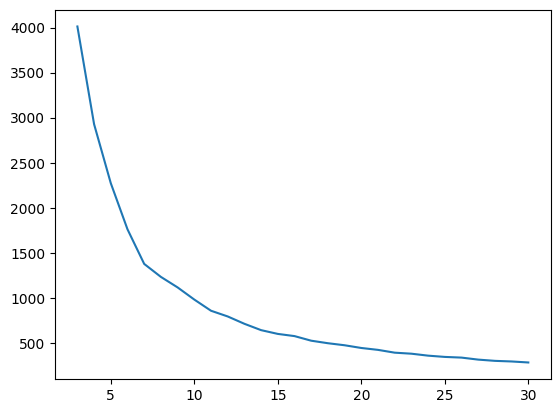

In [131]:
plt.plot(clusters, SSE)

<Axes: xlabel='timediff', ylabel='id'>

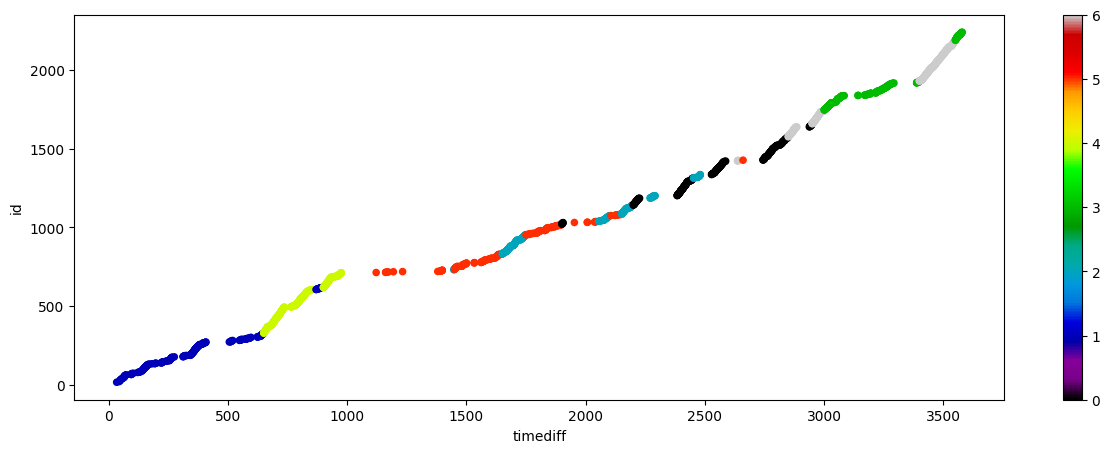

In [132]:
X = df141[vars_for_cluster]
# X = StandardScaler().fit_transform(X)

km = cluster.KMeans(n_clusters=7, n_init=10)
km.fit(X)
c_id = km.fit_predict(X)

fig, ax = plt.subplots(figsize=(15, 5))

df141.plot.scatter(x='timediff', y='id', c=c_id, ax=ax, cmap='nipy_spectral')

array([20, 20, 20, ..., 19, 19, 19])

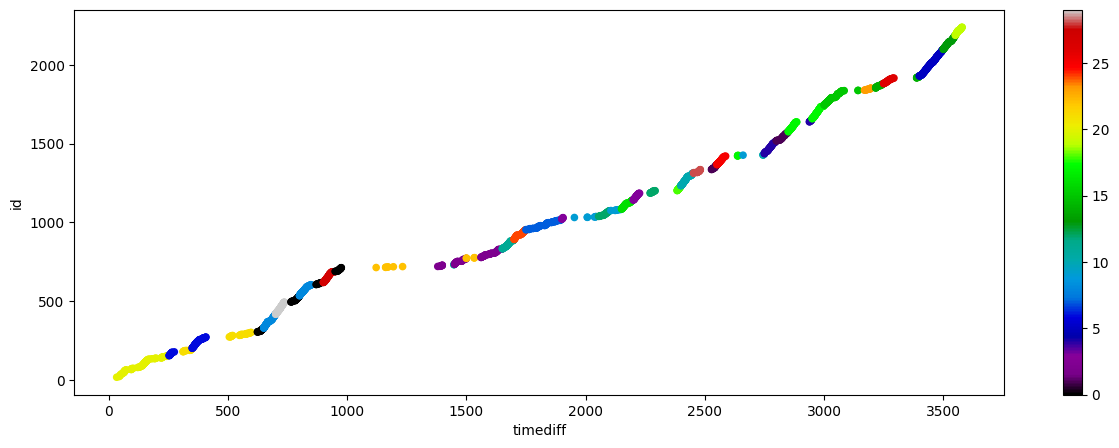

In [133]:
X = df141[vars_for_cluster]
# X = StandardScaler().fit_transform(X)

db = cluster.AgglomerativeClustering(n_clusters=30)
db.fit(X)
c_id = db.fit_predict(X)

fig, ax = plt.subplots(figsize=(15, 5))

df141.plot.scatter(x='timediff', y='id', c=c_id, ax=ax, cmap='nipy_spectral')
c_id

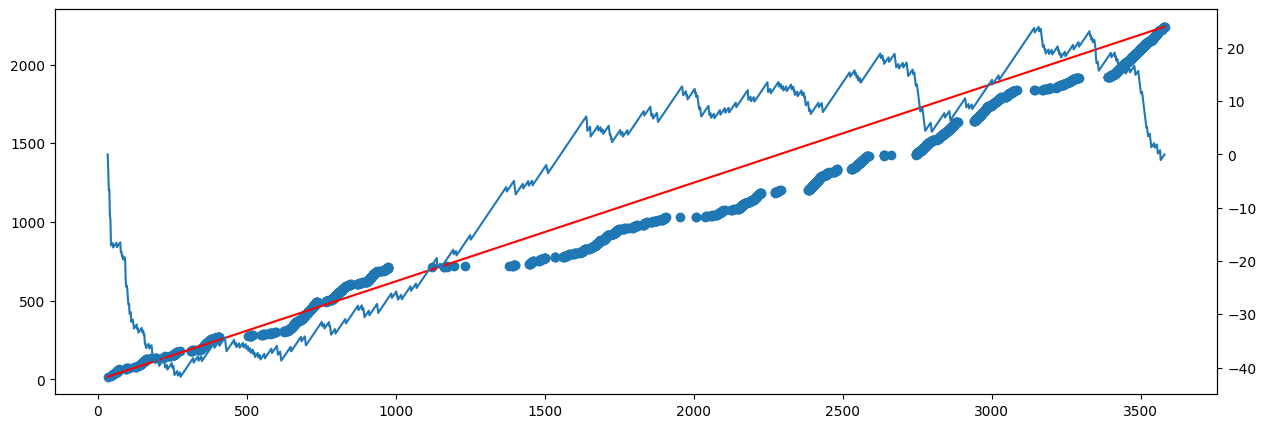

In [15]:
x = df141.timediff.values
y = df141.id.values

X = np.linspace(x[0], x[-1], x.shape[0])
Y = np.linspace(y[0], y[-1], y.shape[0])
dY = Y - y

fig, ax = plt.subplots(figsize=(15, 5), sharex=True)

ax.scatter(x, y)
ax.plot(X, Y, color='red')

ax2 = ax.twinx()
ax2.plot(X, dY)

In [ ]:
import scipy.signal as signal

In [ ]:
x = df141.timediff.values
y = df141.id.values

X = np.linspace(x[0], x[-1], x.shape[0])
Y = signal.detrend(y)

fig, ax = plt.subplots(figsize=(15, 5), sharex=True)

ax.plot(X, dY)